Загрузка старых данных
<br>Старый код

In [73]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

t = pd.read_csv('/home/lk/competitions/household_power_consumption.txt', sep = ';')
columns_for_count = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
t = t[['Date','Sub_metering_1','Sub_metering_2','Sub_metering_3']]
t['Date'] = t['Date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))
# t = t.dropna()

nuns = t[t.isna().any(axis = 1)] 
nuns[:3]

t = t.dropna()
#нужно привести всё к одному типу, а эти вопросительные знаки всё портят. поэтому дропаем. потом зааппендим
for name in columns_for_count:
    t[name] = t[name].astype('float')

# даты с нулевыми значениями повторяются. если мы не учитываем часы, то можно сэкономить на повторениях дня
date_nuns = pd.DataFrame(nuns['Date'].drop_duplicates())

# придется сделать селект для каждого интервала и посчитать мин для каждой колонки.
t.index = t['Date']
date_nuns = date_nuns.join(pd.DataFrame(columns=columns_for_count))
def fill_mean_period(row, days = 1):
#     тут селект и мин
    r = t.loc[row['Date'] - timedelta(days=days) :row['Date'] +  timedelta(days=days)].mean()
    for name in columns_for_count:
        row[name] = r[name]
    return row

# заполняем значения для каждой даты
date_nuns = date_nuns.apply(fill_mean_period,axis=1)

nuns = nuns.drop(columns_for_count,1)
# хорошо, что нулевая вся строка. можно просто смерджить по дате.
date_nuns = nuns.merge(date_nuns, on = 'Date')
# аппендим бывшие нулевые в сет
t = t.append(date_nuns)
                                                                        
                                                                    
for name in columns_for_count:
    t[name] = t[name].astype('float') 
grouped = t.groupby('Date').sum()



/home/lk/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Будем предсказывать вот эти суб метрики. причем каждую по отдельности и потом сложить, т.к. на граффике из предыдущего задания было вижно, что у них разные формы.
<br><br>С аримой я никогда не сталкивалась. но она в статье выглядит как так себе регрессия на самом деле. И судя по всему плохо переживает отсутствующие данные. А вот регрессию я очень даже знаю) просто взять какую нибудь полиномную. мб даже лучше не за весь период. Даты перевести в инты с учетом разрывов. Сделаю пока так.
<br>Добавлю еще дни недели и время года(месяца, чтобы не заморачиваться).

In [30]:
grouped = grouped.reset_index()
grouped = grouped.sort_values('Date')   
grouped['weekday'] = grouped['Date'].apply(lambda x: x.weekday())
grouped.groupby('weekday').mean()

,Sub_metering_1,Sub_metering_2,Sub_metering_3
weekday,,,
0,1193.200000,1259.019512,8922.619512
1,1125.067961,1922.349515,9174.747573
2,1524.107843,2496.568627,9190.357843
3,1143.365854,1084.882927,8623.990244
4,1258.795122,1436.268293,9726.868293
5,2432.414634,2102.356098,10556.151220
6,2565.315271,2708.418719,8449.566502


In [31]:
grouped['month'] = grouped['Date'].apply(lambda x: x.month)
grouped.groupby('month').mean()

,Sub_metering_1,Sub_metering_2,Sub_metering_3,weekday
month,,,,
1,2005.951220,2208.983740,11116.032520,3.008130
2,1629.575221,1995.787611,10920.991150,3.008850
3,1803.330645,2365.629032,9863.548387,2.975806
4,1528.235294,1666.932773,9488.336134,2.949580
5,1778.209677,1883.177419,9643.072581,3.064516
6,1895.033613,1771.966387,8788.714286,2.932773
7,1018.209677,1427.709677,6152.346774,2.983871
8,722.050000,1143.125000,5478.000000,3.033333
9,1641.389831,1682.364407,9025.974576,2.966102


перевод даты в инты

In [32]:
datedif =  grouped.iloc[-1]['Date'] - grouped['Date'] 
datedif = list(map(lambda x: x.days, datedif))
datedif.reverse()
grouped['Datedif'] = datedif
grouped[:4]


,Date,Sub_metering_1,Sub_metering_2,Sub_metering_3,weekday,month,Datedif
0,2006-12-16,0.0,546.0,4926.0,5,12,0
1,2006-12-17,2033.0,4187.0,13341.0,6,12,1
2,2006-12-18,1063.0,2621.0,14018.0,0,12,2
3,2006-12-19,839.0,7602.0,6197.0,1,12,3


Оставалось только скормить фичи в виде даты в инте с учетом разрывов, дня недели и месяца в какую нибудь полиномную линейную регрессию. И тут я с удивлением узнала, что ни одна либа в питоне это не умеет! либо совсем линейно, либо одна фича. боль
<br>Долго думала писать ли свою регрессию или как нибудь наложить линии разных фич..
<br>Пойду сделаю ариму
<br>Но раз мы уже тут, то вот несколько граффиков прогнозов. один и с учетом месяцев

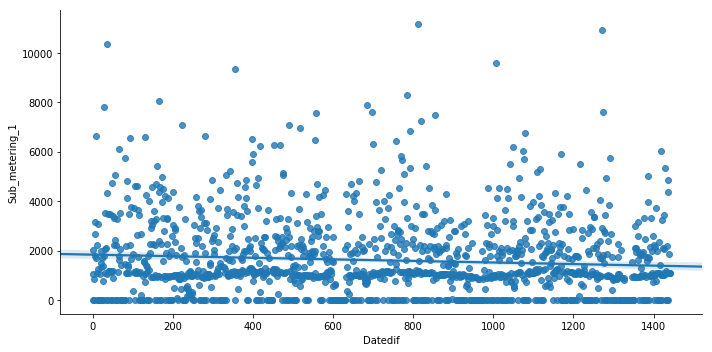

In [33]:
sns.lmplot( x = 'Datedif', y = 'Sub_metering_1', data=grouped, aspect=2 )

фу сколько выбросов. На глаз уберу. Если еще и сигмы считать, то до вечера уже не успею

/home/lk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


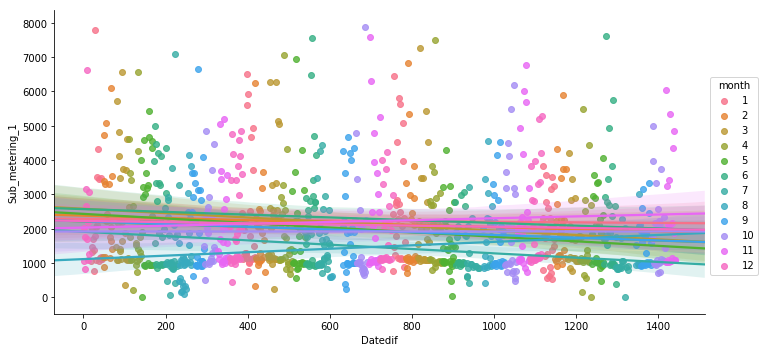

In [39]:
grouped = grouped[grouped['Sub_metering_1'] > 1][grouped['Sub_metering_1'] < 8000]
sns.lmplot( x = 'Datedif', y = 'Sub_metering_1', data=grouped, aspect=2, hue='month')

<br><br><br>
# арима

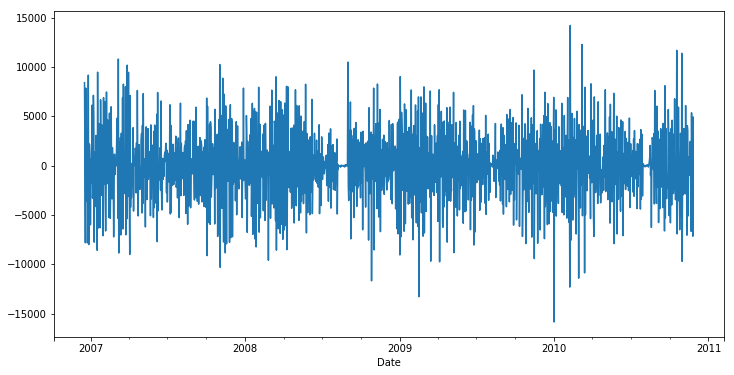

In [112]:
# import statsmodels.api as sm

sub1 = grouped['Sub_metering_3'].diff(periods=1).dropna()
sub1.plot(figsize=(12,6))

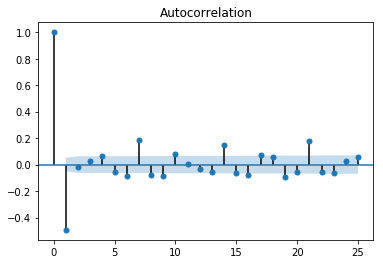

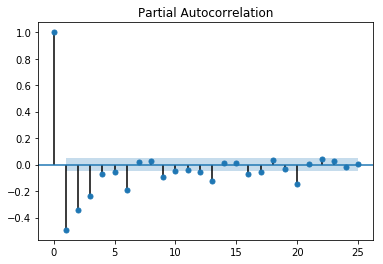

In [113]:
fig = sm.graphics.tsa.plot_acf(sub1.values.squeeze(), lags=25)
fig = sm.graphics.tsa.plot_pacf(sub1, lags=25)


/home/lk/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/lk/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/lk/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/lk/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype 

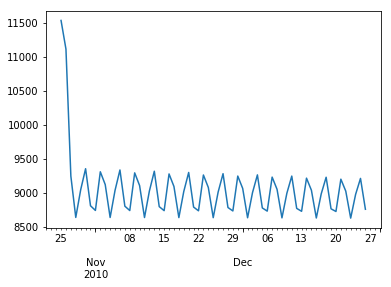

In [121]:
grouped = grouped.asfreq(freq='1D')
model = sm.tsa.ARIMA(grouped['Sub_metering_3'].loc[:'2010-10-26'], order=(2,1,4)).fit(disp=0)
pred = model.predict('2010-10-25','2010-12-26', typ='levels')
pred.plot()

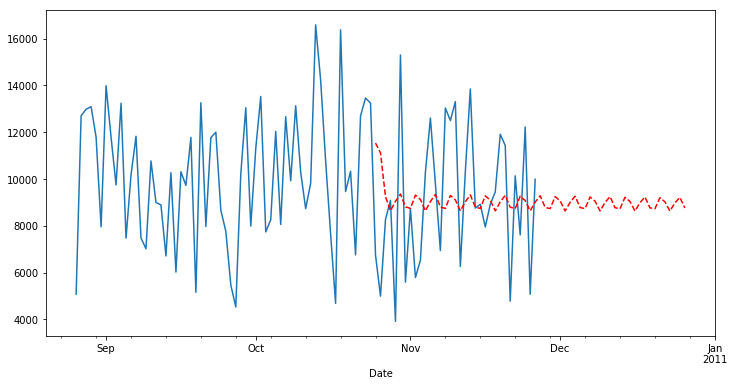

In [119]:
grouped['Sub_metering_3'].loc['2010-08-26':].plot(figsize=(12,6))
pred.plot(style='r--',figsize=(12,6))